## Сжатие полносвязных слоёв в нейросети

Ниже мы будем исследовать, как изменится точность предсказания нейросети, которая классифицирует изображения, если вместо полносвязных слоёв использовать их сжатое представление, полученное с помощью SVD.

#### Сначала скачаем данные CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=True, download=True, transform=transform), 
                                        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=False, transform=transform), 
                                          batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


#### Посмотрим, как выглядят изображения

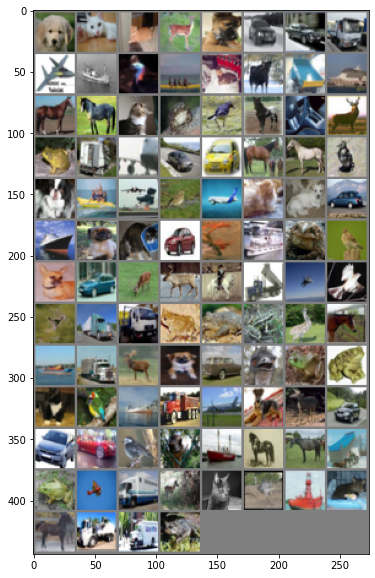

  dog   cat   cat  deer   dog   car   car truck


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


### Архитектура нейронной сети

Для простоты и демонстрации принципа сжатия слоёв нейронных сетей рассмотрим архитектуру, состоящую только из полносвязных слоёв (то есть линейных преобразований) и стандартных ReLU-нелинейностей. Опять же для наглядности выбрали размерность 1000 для полносвязных слоёв. 

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.fc6 = nn.Linear(1000, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)

        y = self.fc2(x)
        y = self.ReLU(y)
        y = self.fc3(y)

        x1 = self.ReLU(y + x)

        
        y1 = self.fc4(x1)
        y1 = self.ReLU(y1)
        y1 = self.fc5(y1)

        x2 = self.ReLU(x1 + y1)

        z = self.fc6(x2)
        return F.log_softmax(z, dim=1)

#### Функции для обучения и тестирования результата после каждого прохождения всех данных 

In [6]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [7]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Зададим параметры обучения и вывода промежуточных результатов

In [8]:
log_interval = 50
epochs = 7

### Запускаем обучение с помощью метода оптимизации Adam


In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, epochs + 1):
    train(model,  train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.315274
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.882945
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.763033
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.353175
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.555685
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.545010
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.691388
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.483624
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.636849
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.509223

Test set: Average loss: 1.4582, Accuracy: 4877/10000 (49%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.419691
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.353276
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.522720
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.329439
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.431186
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.358336
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.490233
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.399020
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.450479
T

# Сингулярные числа

Ниже рассмотрим сингулярные числа для того, чтобы понять оптимальное количество параметров в линейных слоях



In [ ]:
W = model.state_dict()['fc1.weight']
U, S, V = np.linalg.svd(W, full_matrices=False)

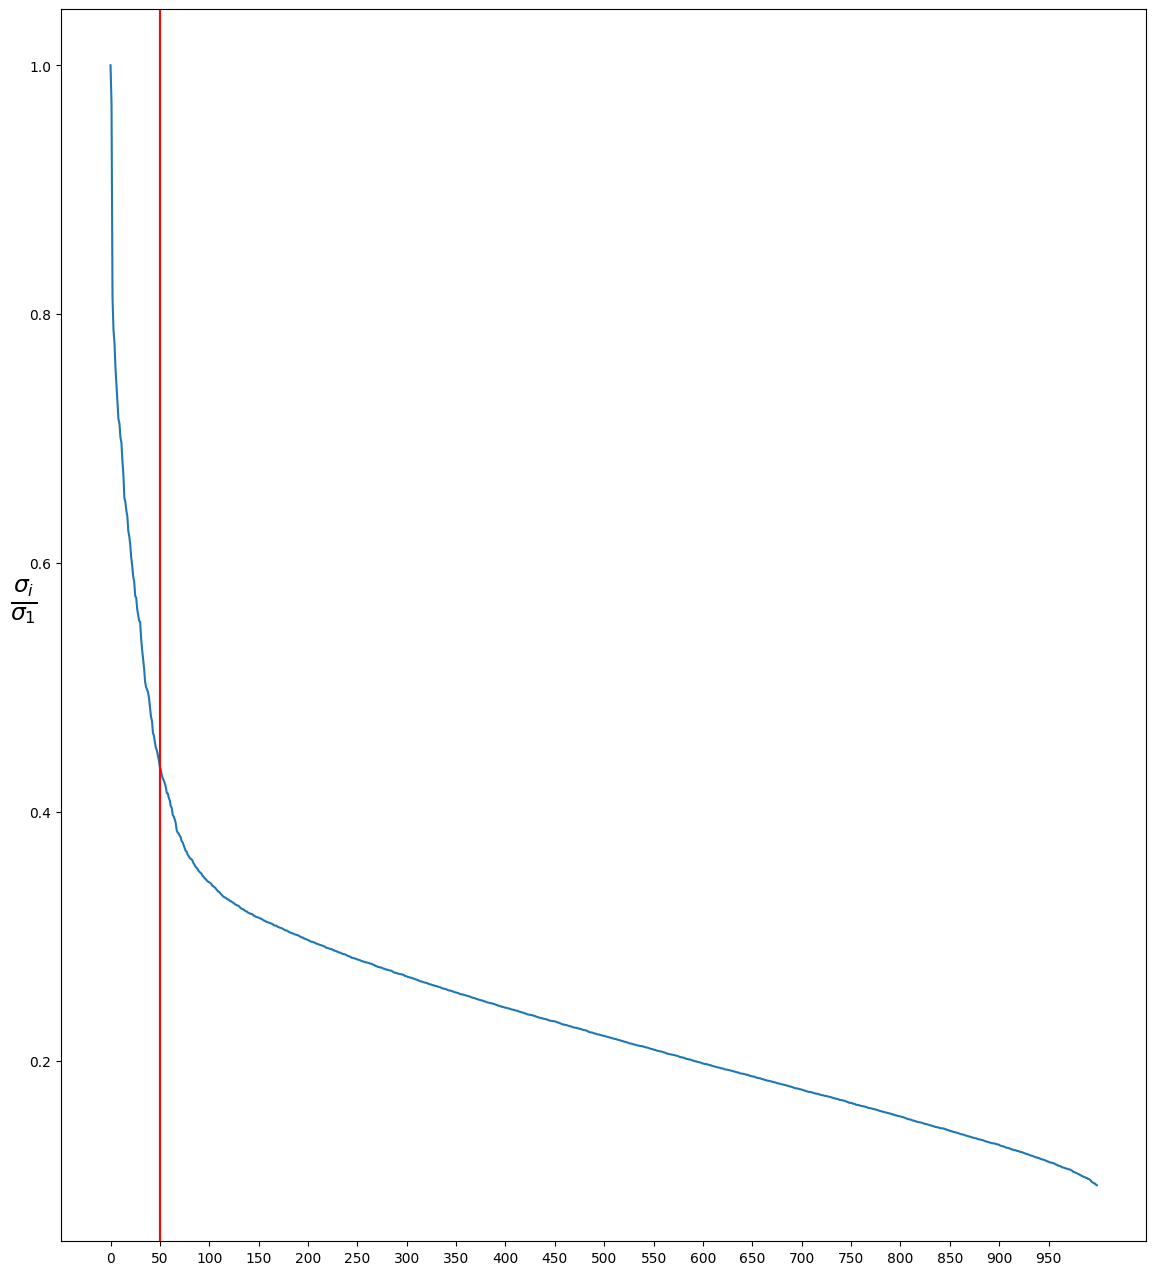

In [ ]:
plt.figure(figsize = (14, 16))
plt.plot(S / S[0])
plt.axvline(x=50, color='r')
plt.xticks(np.arange(0, 1000, 50))
plt.ylabel(r"$\frac{\sigma_i}{\sigma_1}$", fontsize=24, rotation=0)
plt.show()

Видно, что примерно после 50 сингулярного числа, они начинают в относительном значении убывать, но тем не менее матрица достаточно плотная, и нам не следует сильно ее сжимать


Создадим модель, которая на вход будет принимать экземпляр класса ```Net```, ранг $r > 0$ и список индексов слоёв, веса которых будут сжиматься. Эта модель будет сжимать некоторые полносвязные слои (индексы которых переданы на вход) с помощью SVD разложения, из которого берутся только первые $r$ компонент. Также реализуем функцию ```forward``` так, чтобы она эффективно использовала сжатые представления полносвязных слоёв



In [28]:
class TruncatedModel(nn.Module):

    def __init__(self, Net, r=None, indexes=None):
        '''
        Net: object of class Net
        r: int, rank of truncated svd
        indexes: list of int, number of linear layers to truncate. starts from 1
        '''


        super(TruncatedModel, self).__init__()
        self.net = Net
        self.r = r
        self.indexes = indexes
        self.ReLU = torch.nn.ReLU()
        self.n_params = 0
        
        self.truncated_dict = {}

        if r is not None:
            for idx in indexes:
                self.truncate_layer(idx)


    
    def truncate_layer(self, layer_name):
        proper_name = 'fc'+str(layer_name)
        W = self.net.state_dict()[proper_name+'.weight']
        bias = self.net.state_dict()[proper_name+'.bias']

        U, S, Vt = np.linalg.svd(W, full_matrices=False)        

        U_truncated = torch.from_numpy(U[:, :self.r])
        S_truncated = S[:self.r]
        Vt_truncated = Vt[:self.r, :]

        SVt = torch.from_numpy(np.diag(S_truncated)@Vt_truncated)

        U = torch.nn.Parameter(data = U_truncated)
        SVt = torch.nn.Parameter(data = (SVt))

        self.register_parameter(proper_name + '_U', U)
        self.register_parameter(proper_name + '_SVt', SVt)


        self.truncated_dict[layer_name] = (U, SVt, bias)

        
        #self.net.state_dict()[proper_name] = torch.from_numpy(U_truncated@np.diag(S_truncated)@V_truncated)

    def fc_compressed(self, x, layer_name):

        if layer_name in self.indexes:
            return self.compute_compressed(x, layer_name)
        else:
            proper_name = 'fc'+str(layer_name)

            W = self.net.state_dict()[proper_name+'.weight']
            self.n_params += W.size(0)*W.size(1)

            return getattr(model, proper_name)(x)

    def compute_compressed(self, x, layer_name):
        U, SVt, bias = self.truncated_dict[layer_name]

        #print(SVt.size())

        self.n_params += U.size(0)*U.size(1) + SVt.size(0)*SVt.size(1)


        out = (x @ SVt.T) @ U.T + bias.expand(x.shape[0], -1)

        return out



    def forward(self, x):

        x = self.fc_compressed(x.view(-1, 3 * 32*32), 1)
        x = self.ReLU(x)

        y = self.fc_compressed(x, 2)
        y = self.ReLU(y)
        y = self.fc_compressed(y, 3)

        x1 = self.ReLU(y + x)

        
        y1 = self.fc_compressed(x1, 4)
        y1 = self.ReLU(y1)
        y1 = self.fc_compressed(y1, 5)

        x2 = self.ReLU(x1 + y1)

        z = self.fc_compressed(x2, 6)
        out = F.log_softmax(z, dim=1)

        return out



In [29]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    accuracy = correct / len(test_loader.dataset)
    return accuracy

In [31]:
import time
from tqdm import tqdm

In [37]:
compress_layers = [[1], [2], [3], [1,2], [2,3], [1,2,3,4]]

ranks = [10, 30, 50, 70, 100, 200, 300]

results_time = {}
results_accuracy = {}
results_params = {}

for cl in tqdm(compress_layers):
    res_time = []
    res_acc = []
    res_params = []

    for r in ranks:
        
        tr_model = TruncatedModel(model, r = r, indexes=cl)

        

        start = time.time()
        acc = test(tr_model, test_loader)
        end = time.time()

        n_params = tr_model.n_params
        
        res_time.append(end-start)

        res_params.append(n_params)
        res_acc.append(acc)

    results_params[tuple(cl)] = res_params
    results_accuracy[tuple(cl)] = res_acc
    results_time[tuple(cl)] = res_time

  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.3473, Accuracy: 3185/10000 (32%)


Test set: Average loss: 1.6463, Accuracy: 4966/10000 (50%)


Test set: Average loss: 1.3449, Accuracy: 5496/10000 (55%)


Test set: Average loss: 1.3678, Accuracy: 5386/10000 (54%)


Test set: Average loss: 1.3671, Accuracy: 5355/10000 (54%)


Test set: Average loss: 1.3662, Accuracy: 5318/10000 (53%)



 17%|█▋        | 1/6 [00:36<03:02, 36.55s/it]


Test set: Average loss: 1.3685, Accuracy: 5318/10000 (53%)


Test set: Average loss: 1.3700, Accuracy: 5263/10000 (53%)


Test set: Average loss: 1.3488, Accuracy: 5385/10000 (54%)


Test set: Average loss: 1.3504, Accuracy: 5367/10000 (54%)


Test set: Average loss: 1.3549, Accuracy: 5358/10000 (54%)


Test set: Average loss: 1.3619, Accuracy: 5342/10000 (53%)


Test set: Average loss: 1.3685, Accuracy: 5329/10000 (53%)



 33%|███▎      | 2/6 [01:09<02:17, 34.50s/it]


Test set: Average loss: 1.3665, Accuracy: 5339/10000 (53%)


Test set: Average loss: 1.3425, Accuracy: 5369/10000 (54%)


Test set: Average loss: 1.3606, Accuracy: 5343/10000 (53%)


Test set: Average loss: 1.3632, Accuracy: 5345/10000 (53%)


Test set: Average loss: 1.3639, Accuracy: 5352/10000 (54%)


Test set: Average loss: 1.3665, Accuracy: 5363/10000 (54%)


Test set: Average loss: 1.3711, Accuracy: 5328/10000 (53%)



 50%|█████     | 3/6 [01:42<01:40, 33.64s/it]


Test set: Average loss: 1.3736, Accuracy: 5318/10000 (53%)


Test set: Average loss: 2.3394, Accuracy: 3315/10000 (33%)


Test set: Average loss: 1.6369, Accuracy: 4966/10000 (50%)


Test set: Average loss: 1.3287, Accuracy: 5537/10000 (55%)


Test set: Average loss: 1.3540, Accuracy: 5419/10000 (54%)


Test set: Average loss: 1.3572, Accuracy: 5376/10000 (54%)


Test set: Average loss: 1.3589, Accuracy: 5376/10000 (54%)



 67%|██████▋   | 4/6 [02:21<01:11, 35.94s/it]


Test set: Average loss: 1.3602, Accuracy: 5339/10000 (53%)


Test set: Average loss: 1.3733, Accuracy: 5244/10000 (52%)


Test set: Average loss: 1.3431, Accuracy: 5393/10000 (54%)


Test set: Average loss: 1.3433, Accuracy: 5393/10000 (54%)


Test set: Average loss: 1.3472, Accuracy: 5374/10000 (54%)


Test set: Average loss: 1.3545, Accuracy: 5347/10000 (53%)


Test set: Average loss: 1.3631, Accuracy: 5342/10000 (53%)



 83%|████████▎ | 5/6 [02:57<00:35, 35.85s/it]


Test set: Average loss: 1.3645, Accuracy: 5357/10000 (54%)


Test set: Average loss: 2.5487, Accuracy: 3364/10000 (34%)


Test set: Average loss: 1.5935, Accuracy: 5030/10000 (50%)


Test set: Average loss: 1.2881, Accuracy: 5619/10000 (56%)


Test set: Average loss: 1.3161, Accuracy: 5448/10000 (54%)


Test set: Average loss: 1.3268, Accuracy: 5385/10000 (54%)


Test set: Average loss: 1.3404, Accuracy: 5363/10000 (54%)



100%|██████████| 6/6 [03:43<00:00, 37.26s/it]


Test set: Average loss: 1.3495, Accuracy: 5326/10000 (53%)



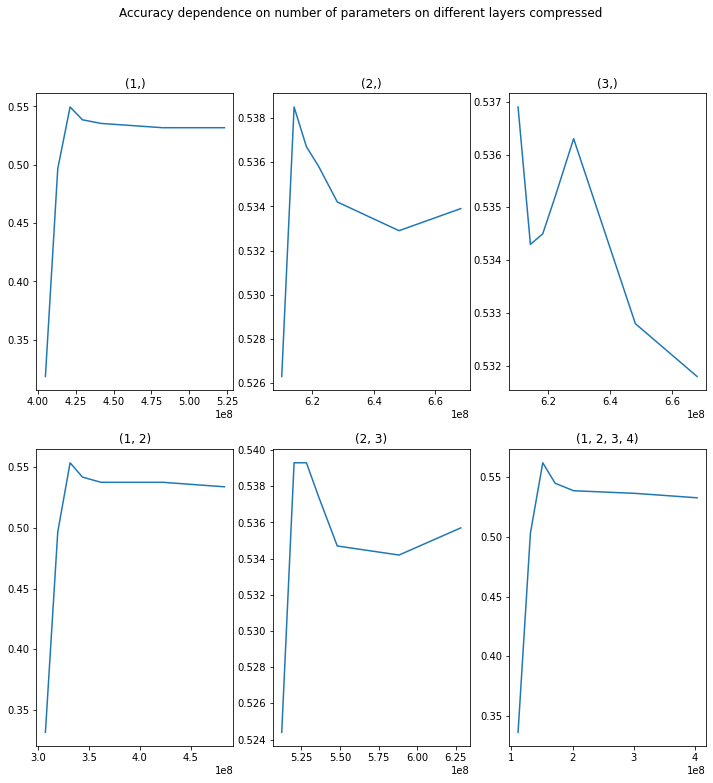

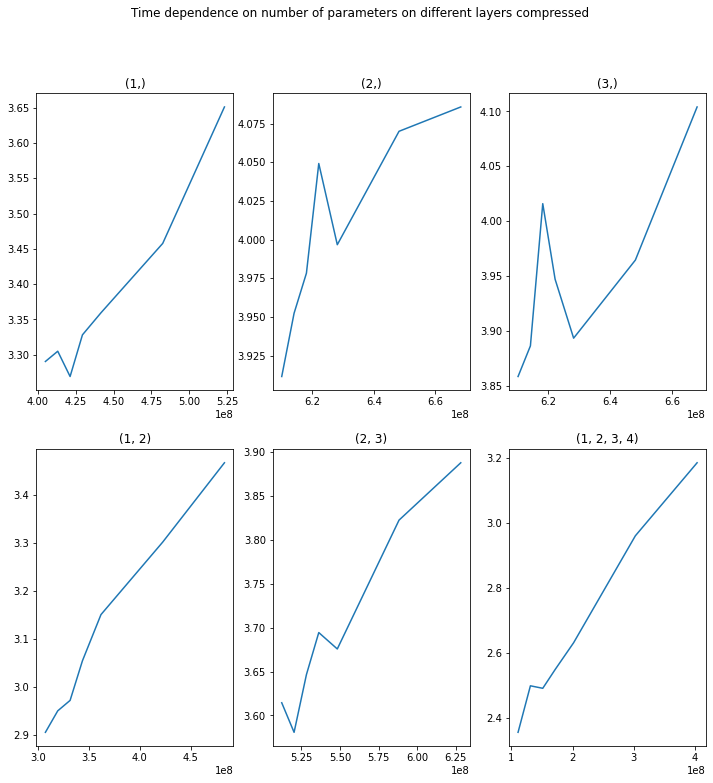

In [44]:

plt.subplots(2,3, figsize=(12,12))
plt.suptitle('Accuracy dependence on number of parameters on different layers compressed')
for i in range(1, 7):
    plt.subplot(2, 3, i) 

    cur_key = list(results_accuracy.keys())[i-1]
    values_params = results_params[cur_key]
    values_accuracy = results_accuracy[cur_key]

    plt.plot(values_params, values_accuracy)
    plt.title('{}'.format(cur_key))
    #plt.xticks(ranks)
    #plt.axis("off") # о

plt.show()



plt.subplots(2,3, figsize=(12,12))
plt.suptitle('Time dependence on number of parameters on different layers compressed')
for i in range(1, 7): 
    plt.subplot(2, 3, i) 

    cur_key = list(results_accuracy.keys())[i-1]
    values_params = results_params[cur_key]
    values_time = results_time[cur_key]

    plt.plot(values_params, values_time)
    plt.title('{}'.format(cur_key))
    #plt.xticks(ranks)
    #plt.axis("off") # о

plt.show()

Относительно времени видим достаточно понятную закономерность. Чем больше параметров, тем дольше считать. Относительно качества иногда видим странные заломы, которых теоретически не должно быть, возможно это связано с оптимальностью подобранного разложения. В общем тренд такой же, как и ниже, связанный с рангом, вначале достаточно быстрый рост качества на низких рангах, где сингулярные числа большиие, а затем постепенно выходим на плато

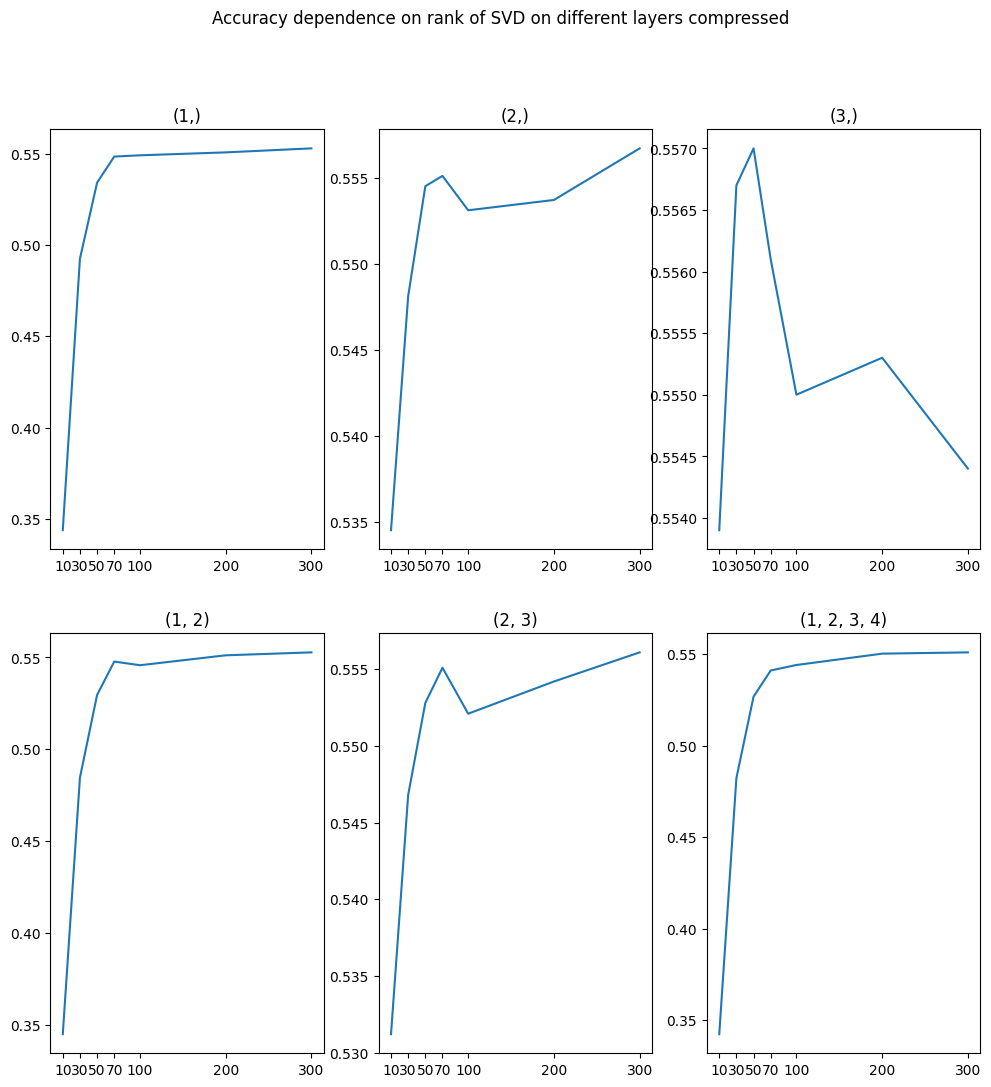

In [ ]:

plt.subplots(2,3, figsize=(12,12))
plt.suptitle('Accuracy dependence on rank of SVD on different layers compressed')
for i in range(1, 7): 
    plt.subplot(2, 3, i) 

    cur_key = list(results_accuracy.keys())[i-1]
    values = results_accuracy[cur_key]
    plt.plot(ranks, values)
    plt.title('{}'.format(cur_key))
    plt.xticks(ranks)
    #plt.axis("off") # о

plt.show()

Видим, что для разных слоев графики могут отличаться, где то даже вести себя странно, но общая тенденция такая, что с увеличением ранга качество растет до определенного момента, а затем выходит на плато. Учитывая ранее проанализированное соотношение сингулярных чисел, как раз заметно, что около 70 выходит на плато, что соответствует графикам сингулярных чисел.

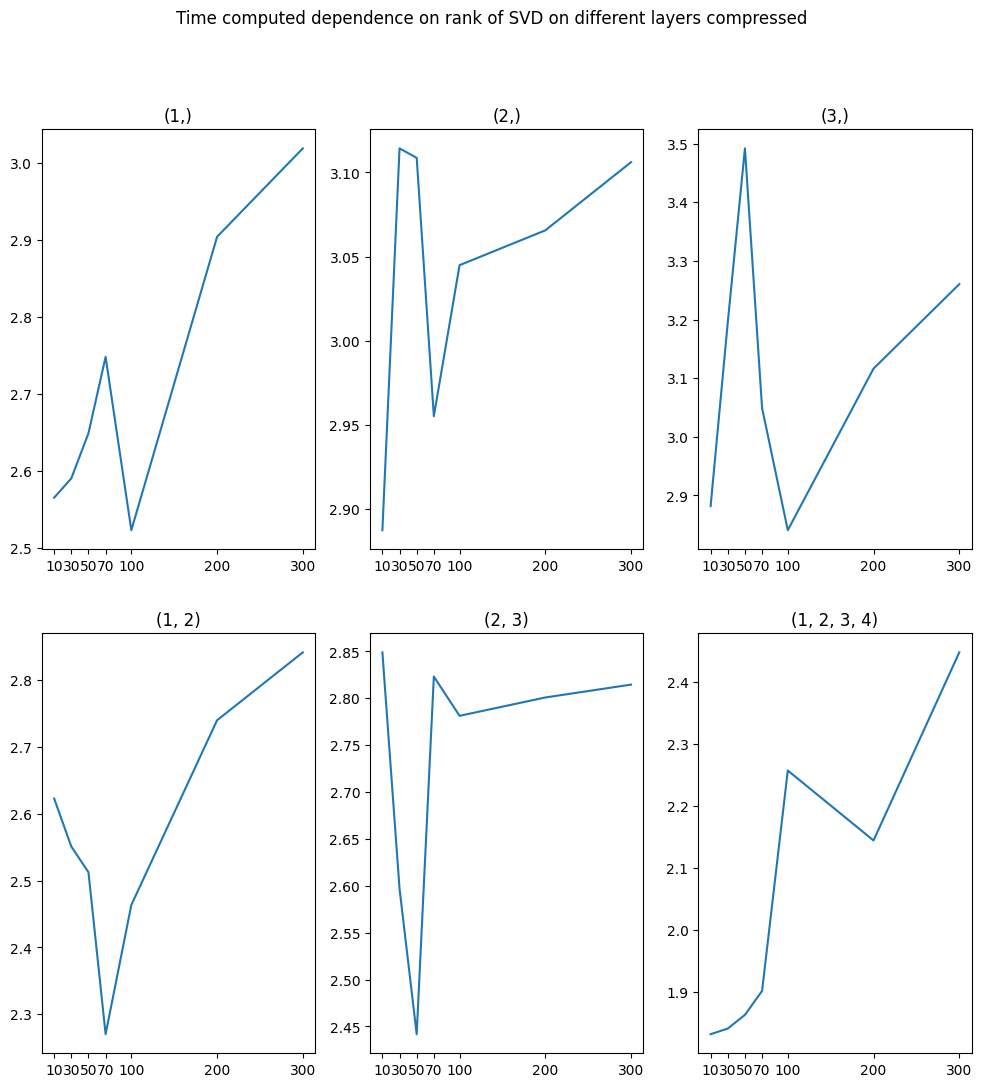

In [ ]:
plt.subplots(2,3, figsize=(12,12))
plt.suptitle('Time computed dependence on rank of SVD on different layers compressed')
for i in range(1, 7): 
    plt.subplot(2, 3, i) 

    cur_key = list(results_time.keys())[i-1]
    values = results_time[cur_key]
    plt.plot(ranks, values)
    plt.title('{}'.format(cur_key))
    plt.xticks(ranks)
    #plt.axis("off") # о

plt.show()

Есть некоторые непонятные скачки, скорее всего это связано чисто с системными вещами, что в некоторые моменты железо решило себя повести странным образом. В общем тренд такой, что чем больше у нас ранг в сжатии слоя, тем дольше будет вычисление. 

### Fine-tuning

Поскольку в нашей модели, которая использует сжатое представление линейных слоёв, параметрами являются матрицы, полученные из SVD соответствующих линейных слоёв, то их также можно оптимизировать. Проведем обучение этих матриц в течение нескольких эпох и сравним насколько выросло качество по сравнению с первоначальными значениями. 

In [16]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
     #   data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          #  data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    accuracy = correct / len(test_loader.dataset)


In [23]:
tr_model = TruncatedModel(model, 50, [1,2,3,4])
optimizer = optim.Adam(model.parameters(), lr=1e-4)

test(tr_model, test_loader)


Test set: Average loss: 1.4513, Accuracy: 4996/10000 (50%)



In [24]:
epochs = 5

for epoch in range(1, epochs + 1):
    train(tr_model,  train_loader, optimizer, epoch)
    acc = test(tr_model, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.162392
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.119653
Train Epoch: 1 [10000/50000 (20%)]	Loss: 0.948646
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.019805
Train Epoch: 1 [20000/50000 (40%)]	Loss: 0.934943
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.115854
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.157582
Train Epoch: 1 [35000/50000 (70%)]	Loss: 0.876445
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.160900
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.021241

Test set: Average loss: 1.2913, Accuracy: 5587/10000 (56%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.892311
Train Epoch: 2 [5000/50000 (10%)]	Loss: 0.962820
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.009790
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.031851
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.966752
Train Epoch: 2 [25000/50000 (50%)]	Loss: 0.922256
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.052734
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.084244
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.915904
T

Видим,что значения точности выросли. В конце чуть чуть переобучились, но в целом это можно было проконтролировать. Это можно связать сразу с несколькими факторами. Первое - то, что ранг нашего разложения сильно ниже, однако мы можем добиться почти такого же качества. Затем лернинг рейт достаточно высокий для такой глубокой сети. Ну и по первой модели было видно, что она недообучена.

Ну а вообще качество мы получили такое же как в нашей изначальной сети, по моему здорово